In [1]:
import tensorflow as tf
from tensorflow import keras
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### **Removing dodgy images**

In [4]:
import cv2
import imghdr

In [5]:
data = 'data'

In [6]:
image_exist = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
num_obs = [0, 0]
class_idx = -1

for image_class in os.listdir(data):
    class_idx = class_idx + 1
    for image in os.listdir(os.path.join(data, image_class)):
        image_pth = os.path.join(data, image_class, image)

        try:
            img = cv2.imread(image_pth)
            tip = imghdr.what(image_pth)
            if tip not in image_exist:
                print('Image not in ext list {}'.format(image_pth))

                os.remove(image_pth)
            
            else:
                num_obs[class_idx] = num_obs[class_idx] + 1

        except Exception as e:
            print('Issue with image {}'.format(image_pth))

**Loading The Data**

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data)

Found 303 files belonging to 2 classes.


In [10]:
class_names = data.class_names
print(class_names)

['happy', 'sad']


<BarContainer object of 2 artists>

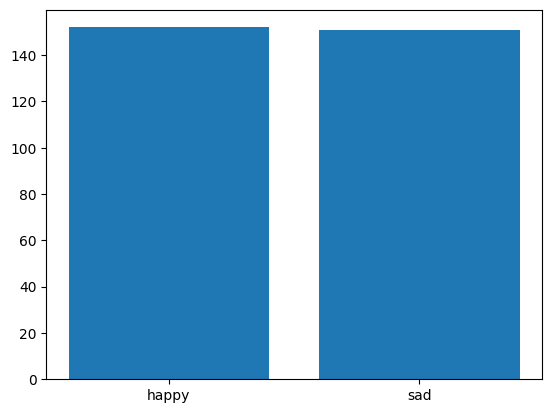

In [11]:
plt.bar([class_names[0], class_names[1]], num_obs)

In [12]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

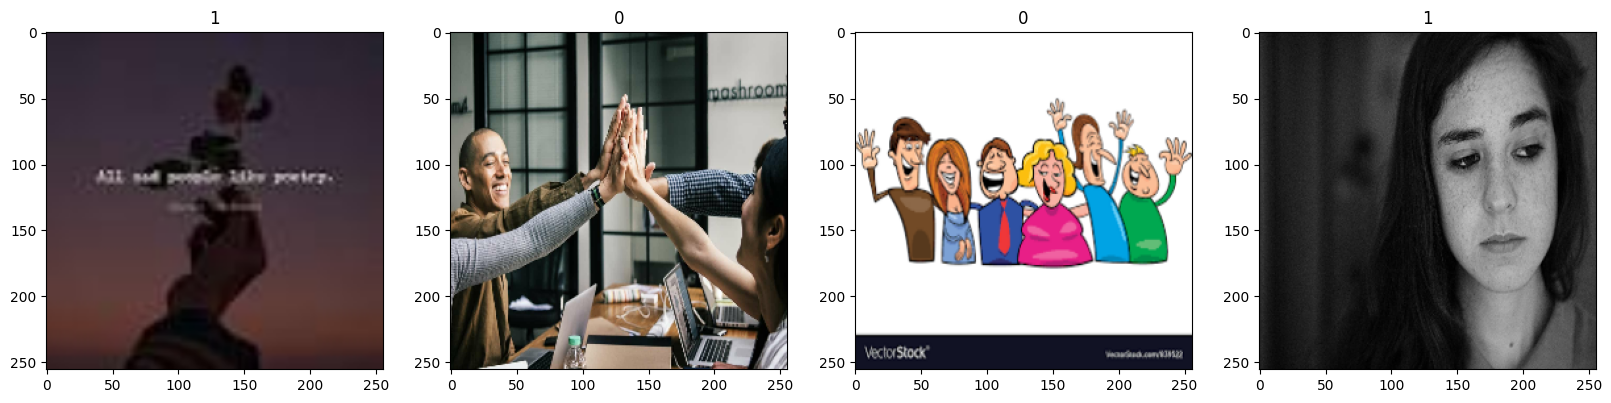

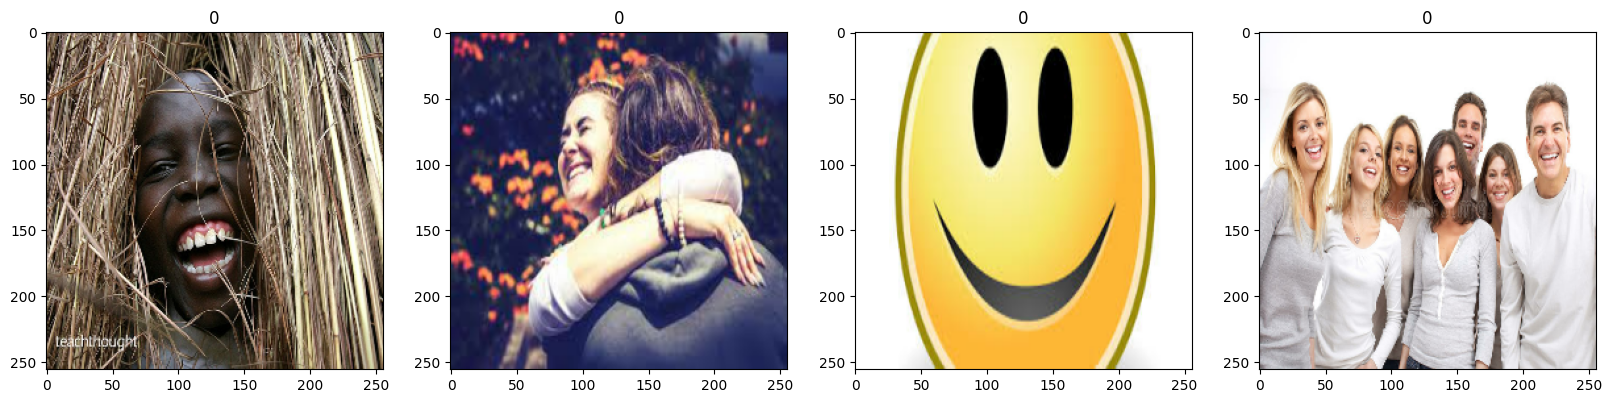

In [13]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][4:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][4 + idx])

**Scalling the data**

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.5064951 , 0.5692402 , 0.52610296],
          [0.5213235 , 0.58406866, 0.54093134],
          [0.5355392 , 0.5982843 , 0.54901963],
          ...,
          [0.9655637 , 0.96164215, 0.953799  ],
          [0.96862745, 0.9647059 , 0.95686275],
          [0.96862745, 0.9647059 , 0.95686275]],
 
         [[0.5064951 , 0.5692402 , 0.52610296],
          [0.5213235 , 0.58406866, 0.54093134],
          [0.5355392 , 0.5982843 , 0.54901963],
          ...,
          [0.9648684 , 0.96094686, 0.9531037 ],
          [0.96544886, 0.9615273 , 0.95368415],
          [0.96544886, 0.9615273 , 0.95368415]],
 
         [[0.5064951 , 0.5692402 , 0.52610296],
          [0.5213235 , 0.58406866, 0.54093134],
          [0.5355392 , 0.5982843 , 0.54901963],
          ...,
          [0.9647059 , 0.9607843 , 0.9529412 ],
          [0.9647059 , 0.9607843 , 0.9529412 ],
          [0.9647059 , 0.9607843 , 0.9529412 ]],
 
         ...,
 
         [[0.8213654 , 0.6761984 , 0.6055413 ],
          [0.82354

**Splitting the data**

In [16]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [17]:
train_size

7

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### **Building the Neural Network**

In [19]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [23]:
model.compile(loss = tf.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              metrics = ['accuracy',
                         tf.keras.metrics.Precision(),
                         tf.keras.metrics.Recall()])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

###  **Training the model**

In [25]:

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
history = model.fit(train, epochs = 30, 
                    validation_data = val,
                    callbacks = [tensorboard_callback])

Epoch 1/30
7/7 [==============================] - 7s 251ms/step - loss: 2.9607 - accuracy: 0.5179 - precision: 0.6000 - recall: 0.2308 - val_loss: 0.6348 - val_accuracy: 0.7031 - val_precision: 0.6279 - val_recall: 0.9000
Epoch 2/30
7/7 [==============================] - 2s 221ms/step - loss: 0.6698 - accuracy: 0.6518 - precision: 0.6883 - recall: 0.4953 - val_loss: 0.5753 - val_accuracy: 0.7188 - val_precision: 0.9500 - val_recall: 0.5278
Epoch 3/30
7/7 [==============================] - 2s 207ms/step - loss: 0.5531 - accuracy: 0.7366 - precision: 0.7843 - recall: 0.6838 - val_loss: 1.0775 - val_accuracy: 0.5938 - val_precision: 1.0000 - val_recall: 0.1034
Epoch 4/30
7/7 [==============================] - 2s 224ms/step - loss: 0.5358 - accuracy: 0.7634 - precision: 0.9091 - recall: 0.5607 - val_loss: 0.6003 - val_accuracy: 0.5625 - val_precision: 0.5484 - val_recall: 1.0000
Epoch 5/30
7/7 [==============================] - 2s 212ms/step - loss: 0.4915 - accuracy: 0.7500 - precision: 0

In [29]:
# Plotting the performance
def plot_matrix(history, class_names):

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 8))
    ls = ['-', '--', '-.']
    j = 0

    for hist in history:
        metric_names = list(hist.history.keys())
        for idx in range(2):
            ax[0, idx].plot(hist.history[metric_names[idx]], linestyle = ls[j], 
            color = 'teal', label = metric_names[idx])

            ax[0, idx].plot(hist.history['val_' + metric_names[idx]], 
            color = 'orange', linestyle = ls[j], label = 'val_' + metric_names[idx])

            ax[0, idx].set_title(metric_names[idx], fontsize = 10)
            ax[0, idx].legend()

        for idx in range(2):
                ax[1,idx].plot(hist.history[metric_names[idx+2]], color='teal', linestyle=ls[j], label=metric_names[idx+2])
                ax[1,idx].plot(hist.history['val_'+metric_names[idx+2]], color='orange', linestyle=ls[j], label='val_'+metric_names[idx+2])
                ax[1,idx].set_title(metric_names[idx+2], fontsize=10)
                ax[1,idx].legend()
        j = j + 1

    fig.suptitle('Evaluation Metrics - ' + class_names[0]+' vs ' + class_names[1], fontsize=20)


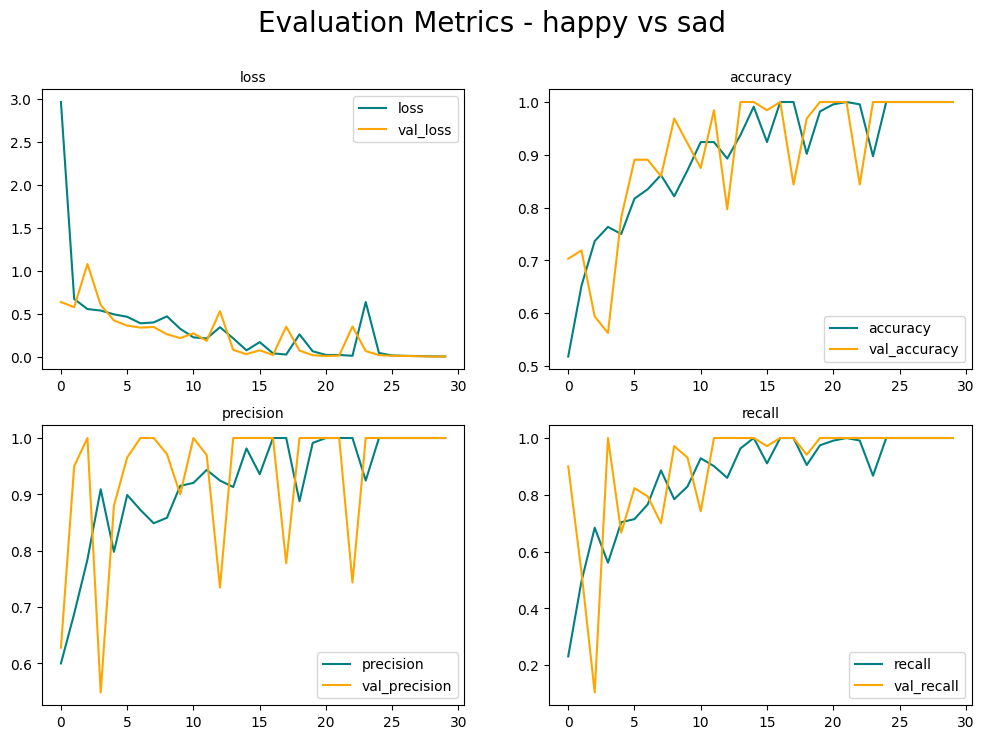

In [30]:
plot_matrix([history], class_names)

In [32]:
base_model_hist = history

### **Evaluation**

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 514ms/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [67]:
# Verify splits
print(f'Train size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}')

Train size: 7, Validation size: 2, Test size: 1


### **Test**

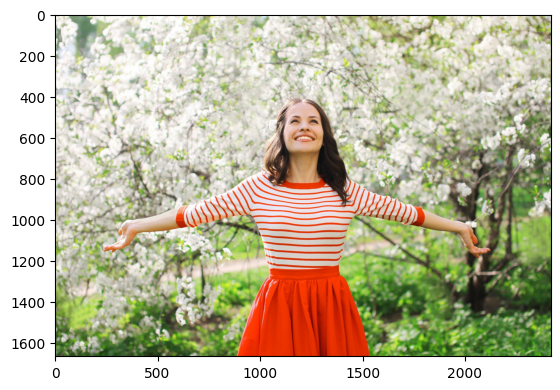

In [58]:
img = cv2.imread('data/happy/happiness.jpg')
img = 255 - cv2.cvtColor(255 - img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

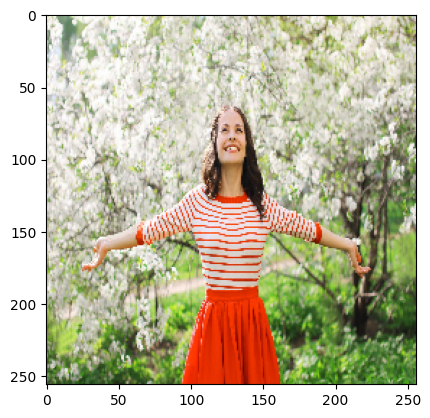

In [59]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [64]:
yhat = model.predict(np.expand_dims(resize / 255, 0))

1/1 [==============================] - 0s 17ms/step


In [65]:
print(yhat)

[[4.577453e-07]]


In [66]:
if yhat < 0.5:
    print(f'Mein Khush Hun...Kyun Nazar laga rahe ho ???')
else:
    print(f'Mera Mood Kharap Hai...chale jao yahan se...')

Mein Khush Hun...Kyun Nazar laga rahe ho ???


1/1 [==============================] - 0s 18ms/step


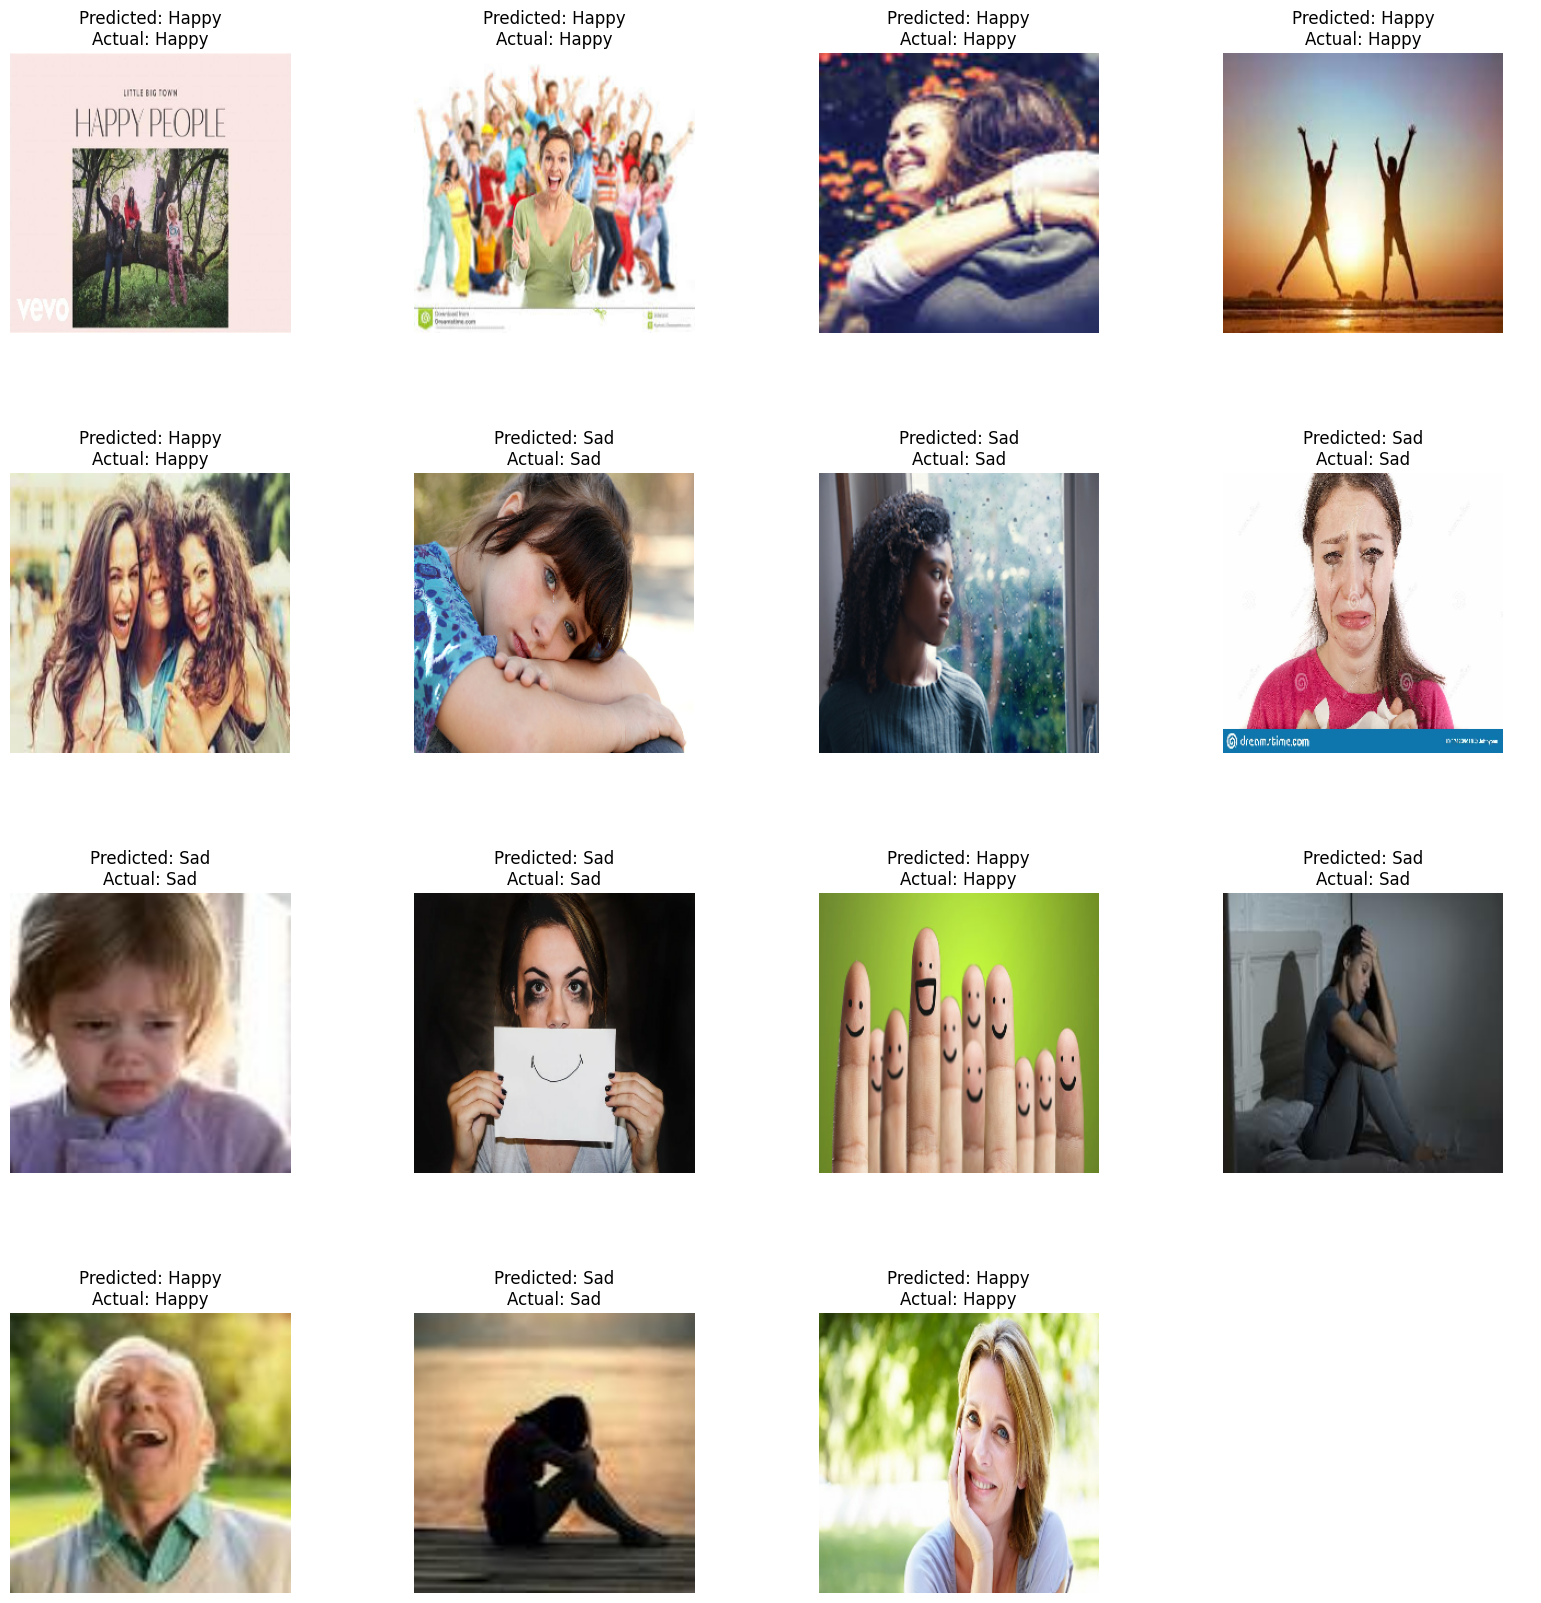

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Set the number of images per page for display
images_per_page = 16

# Flatten test data into a list of all images and labels
test_images, test_labels = [], []

for batch in test:
    images, labels = batch
    test_images.extend(images.numpy())  # Convert to numpy array and add to list
    test_labels.extend(labels.numpy())  # Convert to numpy array and add to list

# Calculate the total number of pages
total_images = len(test_images)
total_pages = math.ceil(total_images / images_per_page)

# Function to display images page by page
def display_test_images_page(page=1):
    fig, axes = plt.subplots(math.ceil(images_per_page / 4), 4, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5)
    axes = axes.flatten()
    
    # Define start and end index for current page
    start_idx = (page - 1) * images_per_page
    end_idx = min(start_idx + images_per_page, total_images)

    # Iterate through images and display on the current page
    for i, idx in enumerate(range(start_idx, end_idx)):
        img = test_images[idx]
        label = test_labels[idx]
        
        # Rescale the image if it's in the [0, 1] range
        img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)
        
        # Predict label
        prediction = model.predict(np.expand_dims(img / 255.0, axis=0))[0][0]
        predicted_label = 'Happy' if prediction < 0.5 else 'Sad'
        actual_label = 'Happy' if label == 0 else 'Sad'
        
        # Display image and labels
        axes[i].imshow(img)
        axes[i].set_title(f'Predicted: {predicted_label}\nActual: {actual_label}')
        axes[i].axis('off')

    # Hide any remaining subplots if fewer than `images_per_page` images
    for j in range(i + 1, images_per_page):
        axes[j].axis('off')
        
    plt.show()

# Display the first page
display_test_images_page(page=1)


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Save the model

model_fname = os.path.join('models', 'image_classifier.h5')
model.save(model_fname)

In [49]:
new_model = load_model(model_fname)

In [50]:
new_model.predict(np.expand_dims(resize / 255, 0))

1/1 [==============================] - 0s 54ms/step


array([[4.577453e-07]], dtype=float32)

In [72]:
import os
import shutil
import numpy as np

# Define the destination directory
destination_folder = 'test'

# Create the folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Initialize a counter to keep track of file names
counter = 1

# Iterate through the test dataset
for batch in test:
    images, labels = batch
    for i in range(len(images)):
        img = images[i].numpy()
        
        # Convert the image back to the 0-255 range if normalized
        img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

        # Determine label-based subfolder (e.g., Happy or Sad)
        label = labels[i].numpy()
        label_folder = 'Happy' if label == 0 else 'Sad'
        
        # Create the label-specific subfolder in the destination
        label_folder_path = os.path.join(destination_folder, label_folder)
        os.makedirs(label_folder_path, exist_ok=True)
        
        # Define the filename for the image
        image_filename = os.path.join(label_folder_path, f'image_{counter}.png')
        
        # Save the image
        cv2.imwrite(image_filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        counter += 1

print(f"All test images have been copied to the '{destination_folder}' folder.")


All test images have been copied to the 'test' folder.
